In [37]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../../../XRaySimulation2")

from XRaySimulation import util
import scipy.signal as sps

import matplotlib
from scipy.interpolate import RegularGridInterpolator
from matplotlib.colors import LogNorm

matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['font.size'] = 12

# Step1 : Get the total scattering volume

In [38]:
def add_weight_cylinder(start, direction, fwhm_xy, space, attenuation_length_um, surface_point, surface_normal,
                        beam_attenaution=False):
    # Get the distance
    l_pixel = (space - surface_point[np.newaxis, np.newaxis, np.newaxis, :])
    l_pixel = np.dot(l_pixel, surface_normal)
    l_pixel /= np.dot(direction, surface_normal)

    # Get a mask such that we only keep the pixel inside the surface
    sample_mask = (l_pixel >= 0)

    # Get a mask that only consider space inside the cylinder
    displacement = (space - start[np.newaxis, np.newaxis, np.newaxis, :])
    deviation = displacement - np.multiply(np.dot(displacement, direction)[:, :, :, np.newaxis],
                                           direction[np.newaxis, np.newaxis, np.newaxis, :])
    displacement_x = deviation[:, :, :, 0]
    displacement_yz = np.sqrt(deviation[:, :, :, 1] ** 2 + deviation[:, :, :, 2] ** 2)

    # Check if the pixel is within the volume of illumination
    x_ray_mask = (displacement_x ** 2 / fwhm_xy[0] ** 2 + displacement_yz ** 2 / fwhm_xy[1] ** 2 - 1 <= 0)
    total_mask = np.multiply(sample_mask, x_ray_mask)

    # Add the weight according to the attenuation coefficient
    weight = np.zeros_like(displacement_x, dtype=np.float64)
    weight[total_mask] = np.exp(-l_pixel[total_mask] / attenuation_length_um)

    if beam_attenaution:
        print("Get get the weight assuming a Gaussian X-ray profile")
        sigma_x = util.fwhm_to_sigma(fwhm=fwhm_xy[0])
        sigma_y = util.fwhm_to_sigma(fwhm=fwhm_xy[1])

        weight *= np.exp(- displacement_x ** 2 / sigma_x ** 2 / 2) / np.sqrt(np.pi * 2) / sigma_x
        weight *= np.exp(- displacement_yz ** 2 / sigma_y ** 2 / 2) / np.sqrt(np.pi * 2) / sigma_y

    else:
        print("Get get the weight assuming a flat X-ray profile")

    return weight

In [39]:
#kin = np.array([-1398.73758358, -19381.33420562, 45704.44855449])
kin = np.array([-0.11689482, -1.97294018, 4.55617549]) * 1e4
kin_len = np.linalg.norm(kin)
kin_direction = kin / kin_len 

tilt_angle = np.deg2rad(11.5)
surface_normal = np.array([-np.cos(tilt_angle), 0, np.sin(tilt_angle)])

beam_size_x = 5.  # um
beam_size_y = 10.  # um
coh_length = 10 * util.c  # um

# Get the sigma
beam_sigma_x = util.intensity_fwhm_to_field_sigma(fwhm=beam_size_x)
beam_sigma_y = util.intensity_fwhm_to_field_sigma(fwhm=beam_size_y)
beam_sigma_z = util.intensity_fwhm_to_field_sigma(fwhm=coh_length)

nx = 256
ny = 64
nz = 256 * 2

dx = 11.8 / 100 / 2
dy = 3. / 4
dz = 0.5 / 6

volume = np.zeros((nx, ny, nz, 3))
volume[:, :, :, 0] = np.linspace(-nx * dx / 2, nx * dx / 2, num=nx)[:, np.newaxis, np.newaxis]
volume[:, :, :, 1] = np.linspace(-ny * dy / 2, ny * dy / 2, num=ny)[np.newaxis, :, np.newaxis]
volume[:, :, :, 2] = np.linspace(-nz * dz / 2, nz * dz / 2, num=nz)[np.newaxis, np.newaxis, :]

In [40]:
# Get the total weight
weight_pulse1 = add_weight_cylinder(start=np.array([-0., 0., 0.]),
                                    direction=np.array([np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[beam_size_x, beam_size_y],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.array([0., 0., 0.]),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse2 = add_weight_cylinder(start=np.array([0., -0., 0.]),
                                    direction=np.array([-np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[beam_size_x, beam_size_y],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.array([0., 0., 0.]),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse3 = add_weight_cylinder(start=np.array([0., 0., 0.]),
                                    direction=kin_direction,
                                    fwhm_xy=[beam_size_x, beam_size_y],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.array([0., -0., 0.]),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse1[weight_pulse1 < np.max(weight_pulse1) * 1e-6] = 0.
weight_pulse2[weight_pulse2 < np.max(weight_pulse2) * 1e-6] = 0.
weight_pulse3[weight_pulse3 < np.max(weight_pulse3) * 1e-6] = 0.

Get get the weight assuming a Gaussian X-ray profile
Get get the weight assuming a Gaussian X-ray profile
Get get the weight assuming a Gaussian X-ray profile


In [41]:
# Get the scattering volume
scatter_volume = np.multiply(weight_pulse1 * weight_pulse2, weight_pulse3)
scatter_volume[weight_pulse1 > 100 * weight_pulse2] = 0
scatter_volume[weight_pulse2 > 100 * weight_pulse1] = 0
scatter_volume[weight_pulse3 < 1e-3 * np.max(weight_pulse3)] = 0

# Normalize the scatter_volume 
total_vol = np.sum(np.multiply(weight_pulse3 > np.max(weight_pulse3) / np.exp(1),
                               np.multiply(weight_pulse1 > np.max(weight_pulse1) / np.exp(1),
                                           weight_pulse2 > np.max(weight_pulse2) / np.exp(1)),
                               ))

total_vol *= dx * dy * dz # * (1e-6) ** 3
#total_vol = 50 * 30
print(total_vol)

395.779375


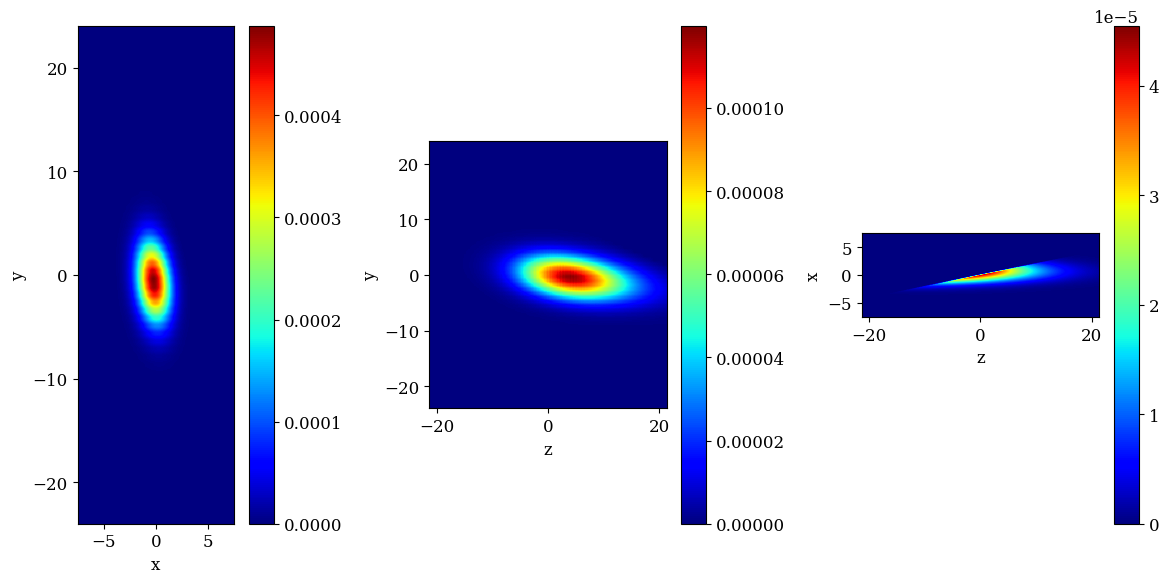

In [42]:
weight_xy = np.sum(scatter_volume, axis=-1)
weight_xz = np.sum(scatter_volume, axis=1)
weight_yz = np.sum(scatter_volume, axis=0)

fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_figheight(6)
fig.set_figwidth(12)
im1 = axes[0].imshow(weight_xy.T, extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                     origin='lower')
fig.colorbar(im1, ax=axes[0])
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

im2 = axes[1].imshow(weight_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                     origin='lower')
fig.colorbar(im2, ax=axes[1])
axes[1].set_xlabel("z")
axes[1].set_ylabel("y")

im3 = axes[2].imshow(weight_xz, extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet',
                     origin='lower')
fig.colorbar(im3, ax=axes[2])
axes[2].set_xlabel("z")
axes[2].set_ylabel("x")

plt.tight_layout()
plt.show()

In [43]:
## Get the volume assuming full coherence
w_volume_fft = np.fft.fftshift(np.fft.fftn(scatter_volume))
w_volume_fft /= np.max(np.abs(w_volume_fft))
w_volume_fft *= total_vol
w_volume_ideal = np.square(np.abs(w_volume_fft))

kx = np.fft.fftshift(np.fft.fftfreq(n=nx, d=dx)) * np.pi * 2  #/ 1e4
ky = np.fft.fftshift(np.fft.fftfreq(n=ny, d=dy)) * np.pi * 2  #/ 1e4
kz = np.fft.fftshift(np.fft.fftfreq(n=nz, d=dz)) * np.pi * 2  #/ 1e4

proj_yz_ideal = np.sum(w_volume_ideal, axis=0)
proj_xz_ideal = np.sum(w_volume_ideal, axis=1)
proj_xy_ideal = np.sum(w_volume_ideal, axis=2)

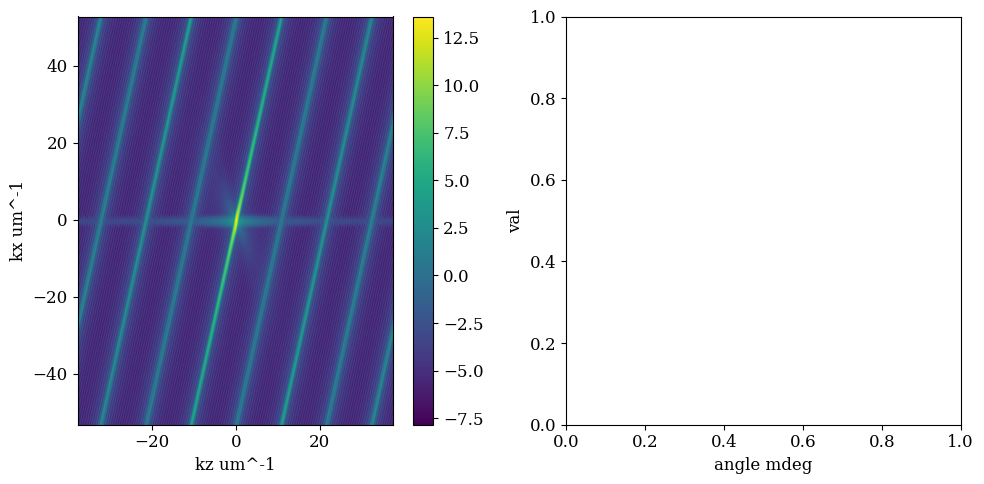

In [44]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

img1 = axes[0].imshow(np.log(proj_xz_ideal), extent=[kz[0], kz[-1], kx[0], kx[-1]], aspect='auto')
fig.colorbar(img1, ax=axes[0])
axes[0].set_xlabel("kz um^-1")
axes[0].set_ylabel("kx um^-1")

axes[1].set_xlabel("angle mdeg")
axes[1].set_ylabel("val")

plt.tight_layout()
plt.savefig("rocking_fit.png", dpi=300, bbox_inches='tight')
plt.show()

# Get the q-smearing function

In [45]:
g_vec = np.array([3.11361484, 3.2118638, -0.83751243]) * 1e4  # um^-1
g_dir = g_vec / np.linalg.norm(g_vec)
n_dir1 = np.array([g_vec[1], -g_vec[0], 0.])
n_dir1 /= np.linalg.norm(n_dir1)
n_dir2 = np.cross(g_dir, n_dir1)
n_dir2 /= np.linalg.norm(n_dir2)

# I would like to know what is the difference if there is a 5 mdeg angular difference
max_delta = np.linalg.norm(g_vec) * np.sin(np.deg2rad(3.7e-3))

# Therefore, one needs to consider the Q smearing along the normal direction of the g_vec
# Construct the Q average mask
q_vol = np.zeros((nx, ny, nz, 3))
q_vol[:, :, :, 0] = kx[:, np.newaxis, np.newaxis]
q_vol[:, :, :, 1] = ky[np.newaxis, :, np.newaxis]
q_vol[:, :, :, 2] = kz[np.newaxis, np.newaxis, :]

sigma_g_p = 0.1  # um
sigma_g_n = util.fwhm_to_sigma(2 * max_delta)  # um

q_weight = np.exp(- 0.5 * (np.dot(q_vol, g_dir) ** 2 / sigma_g_p ** 2 +
                           np.dot(q_vol, n_dir1) ** 2 / sigma_g_n ** 2 +
                           np.dot(q_vol, n_dir2) ** 2 / sigma_g_n ** 2))

q_weight /= np.sum(q_weight)

# Get the q smeared scattering volume

In [46]:
### Get the total volume
w_volume_mosaic = sps.fftconvolve(w_volume_ideal, q_weight, mode='same')

### Get the projection
proj_yz = np.sum(w_volume_mosaic, axis=0)
proj_xz = np.sum(w_volume_mosaic, axis=1)
proj_xy = np.sum(w_volume_mosaic, axis=2)

# Have a rough estimation of the efficiency to see if it makes sense or not

#### Have an estimation of the dOmega * W(Q) term

In [47]:
kout = kin + g_vec
kout_dir = kout / np.linalg.norm(kout)

# Develop an efficient method to cut through the reciprocal space
pixel_center = 120e3 / kout_dir[-1] * kout_dir
det_distance = np.linalg.norm(pixel_center)

# Sample the pixel
pix_nx = 256
x_coor_p = np.linspace(start=-75 / 2., stop=75 / 2., num=pix_nx) + pixel_center[0]

pix_ny = 256
y_coor_p = np.linspace(start=-75 / 2., stop=75 / 2., num=pix_ny) + pixel_center[1]

pixel_pos_mesh = np.zeros((pix_nx, pix_ny, 3))
pixel_pos_mesh[:, :, 0] = x_coor_p[:, np.newaxis]
pixel_pos_mesh[:, :, 1] = y_coor_p[np.newaxis, :]
pixel_pos_mesh[:, :, 2] = 120e3

# calculate the Q for each sampling
pixel_dir = pixel_pos_mesh / np.linalg.norm(pixel_pos_mesh, axis=-1)[:, :, np.newaxis]
pix_Q_mesh = pixel_dir - kin_direction[np.newaxis, np.newaxis, :]
pix_Q_mesh *= np.linalg.norm(kin)

pix_q_mesh = pix_Q_mesh - (kout - kin)[np.newaxis, np.newaxis, :]
pix_q_middle = np.mean(pix_q_mesh, axis=(0, 1))
#pix_q_middle[2] += kin_len * (0.2 / 9.8e3)
pix_q_mesh -= pix_q_middle[np.newaxis, np.newaxis, :]

# This is the pixel q mesh used to integrate the measurement
### This is not the original dOmega, this is the domega for the pixel q mesh integral
dOmega = (x_coor_p[1] -  x_coor_p[0]) *  (y_coor_p[1] -  y_coor_p[0]) / det_distance ** 2
dOmega *= np.dot(np.array([0., 0., 1.,]), kin_direction)

In [48]:
# Get the maximal W result!
interp_ideal = RegularGridInterpolator((kx, ky, kz), w_volume_ideal, bounds_error=False, fill_value=0.0, method='linear')
w_fit_ideal = interp_ideal(pix_q_mesh.reshape((pix_nx * pix_ny, 3)))
w_fit_ideal_2d = np.copy(w_fit_ideal.reshape(pix_nx, pix_ny))

interp_mosaic = RegularGridInterpolator((kx, ky, kz), w_volume_mosaic, bounds_error=False, fill_value=0.0, method='linear')
w_fit_mosaic = interp_mosaic(pix_q_mesh.reshape((pix_nx * pix_ny, 3)))
w_fit_mosaic_2d = np.copy(w_fit_mosaic.reshape(pix_nx, pix_ny))

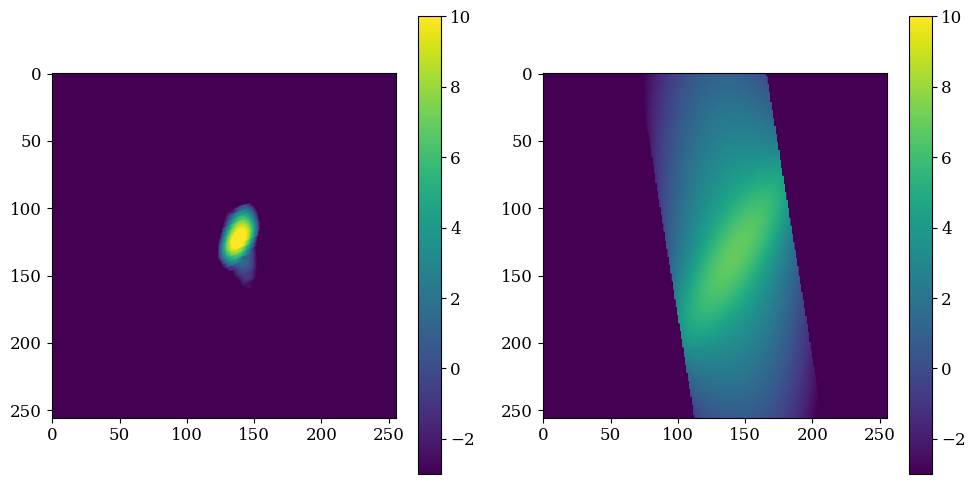

In [49]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

im1 = axes[0].imshow(np.log(w_fit_ideal_2d + 1e-30), vmin=-3, vmax=10)
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(np.log(w_fit_mosaic_2d + 1e-30), vmin=-3, vmax=10)
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

In [50]:
w_ideal = np.sum(w_fit_ideal_2d) * dOmega
w_mosaic = np.sum(w_fit_mosaic_2d) * dOmega
print("{:.2e}".format(w_ideal))
print("{:.2e}".format(w_mosaic))

2.41e-05
6.56e-06


In [51]:
# Calculate the efficiency
I_in = 25.8 * 0.3 * 0.9 * 6.24150907e12 / 9.8e3 # Use the pump fluence to approximate the probe fluence
print("{:.2e} photon/pulse".format(I_in))
eta_exp = 14 / 9.8 / I_in
print("eta = {:.2e}".format(eta_exp))


# Get the polarization factor P^2
po = np.array([0, 1., 0])  # probe X-ray normalization
po -= np.dot(po, kin_direction) * kin_direction
po /= np.linalg.norm(po)
p = 1 - np.dot(po, kout_dir) ** 2

# Get the electric susceptibility
chi220 = complex(0.10376E-04, -0.60756E-06)

# Get the reciprocal lattice component
h_dot_u = g_vec[0]

# Get the simulation efficiency
eta_simu = p / (16 * np.pi ** 2) * kin_len ** 4 * np.abs(chi220) ** 2 * h_dot_u ** 2 * w_mosaic # * (75 /120e3) ** 2 * total_vol ** 2


print(eta_exp)
print(eta_simu)
print(eta_exp / eta_simu)

u_0 = np.sqrt(eta_exp / eta_simu) * 1e4 # A.
print("--------------------------------------------")
print(u_0)
print(u_0 / 3.9)
print("unit cell change:{:.2e} %".format(u_0 * (np.pi * 2 / 118) * 100))
print("\delta T={:.2e}K".format(u_0 * (np.pi * 2 / 118) / 11.1e-6))

4.44e+09 photon/pulse
eta = 3.22e-10
3.219993237443425e-10
19218048979.86504
1.675504751193551e-20
--------------------------------------------
1.2944128982645187e-06
3.319007431447484e-07
unit cell change:6.89e-06 %
\delta T=6.21e-03K


In [52]:
wavelength = np.pi * 2 / kin_len #* 1e-6
r_e = 2.818e-15 * 1e6
v_cell = (3.909e-10 * 1e6) ** 3

f220 = np.pi * v_cell / r_e / wavelength ** 2 * chi220
print(f220)

(43.16734593059176-2.527636150114719j)
